In [7]:
%matplotlib inline
import os
import glob
import shelve
import numpy as np
from pprint import pprint
from matplotlib import pyplot as plt, ticker
import isce
import isceobj
from mintpy.utils import ptime, readfile, writefile, plot as pp
from tools.simulation import iono
plt.rcParams.update({'font.size': 12})

proj_dir = os.path.expanduser('~/data/geolocation/KyushuAlos2DT23')
work_dir = proj_dir
os.chdir(work_dir)
print('Go to directory:', work_dir)

Go to directory: /Users/yunjunz/data/geolocation/KyushuAlos2DT23


### Read bulk offset time-series: stripmapStack -> HDF5/MintPy

azimuth single-look pixel size [m]: 2.35
range   single-look pixel size [m]: 1.43
delete exsited file: /Users/yunjunz/data/geolocation/KyushuAlos2DT23/mintpy_offset/timeseriesAz.h5
create HDF5 file: /Users/yunjunz/data/geolocation/KyushuAlos2DT23/mintpy_offset/timeseriesAz.h5 with w mode
create dataset /timeseries of float32    in size of (49, 325, 290)       with compression=None
create dataset /bperp      of float32    in size of (49,)      with compression=None
create dataset /date       of |S8        in size of (49,)      with compression=None
finished writing to /Users/yunjunz/data/geolocation/KyushuAlos2DT23/mintpy_offset/timeseriesAz.h5
create HDF5 file: /Users/yunjunz/data/geolocation/KyushuAlos2DT23/mintpy_offset/timeseriesRg.h5 with w mode
create dataset /timeseries of float32    in size of (49, 325, 290)       with compression=None
create dataset /bperp      of float32    in size of (49,)      with compression=None
create dataset /date       of |S8        in size of (49,)   

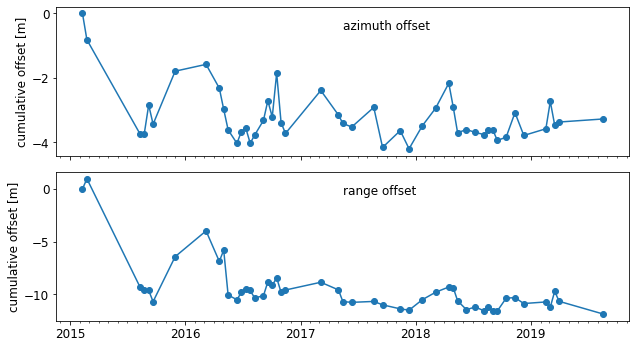

In [9]:
##### get date_list
date_dirs = sorted(glob.glob(os.path.join(proj_dir, 'refineSlaveTiming/dates/*')))
date_list = [os.path.basename(i) for i in date_dirs]
num_date = len(date_list)

##### read az/rg offset time-series
az_off = np.zeros(num_date, dtype=np.float32)
rg_off = np.zeros(num_date, dtype=np.float32)
for i, date_str in enumerate(date_list):
    fname = os.path.join(proj_dir, 'refineSlaveTiming/dates', date_str, 'misreg')
    with shelve.open(fname, flag='r') as f:
        azpoly = f['azpoly']
        rgpoly = f['rgpoly']
    az_off[i] = azpoly.getCoeffs()[0][0]
    rg_off[i] = rgpoly.getCoeffs()[0][0]

# pixel -> meter
ref_ts_file = ref_ts_file = os.path.join(proj_dir, 'mintpy/timeseries.h5')
atr = readfile.read_attribute(ref_ts_file)
az_pixel_size = float(atr['AZIMUTH_PIXEL_SIZE']) / int(atr['ALOOKS'])
rg_pixel_size = float(atr['RANGE_PIXEL_SIZE']) / int(atr['RLOOKS'])
print('azimuth single-look pixel size [m]: {:.2f}'.format(az_pixel_size))
print('range   single-look pixel size [m]: {:.2f}'.format(rg_pixel_size))
az_off *= az_pixel_size
rg_off *= rg_pixel_size

##### write to HDF5/MintPy time-series file
# metadata - remove unrelevant items
for key in list(atr.keys()):
    if key.startswith(('isce.', 'mintpy.', 'REF_')):
        atr.pop(key)
atr['DATA_TYPE'] = 'float32'
atr['REF_DATE'] = date_list[0]
atr['FILE_TYPE'] = 'timeseries'

# dataset
length, width = int(atr['LENGTH']), int(atr['WIDTH'])
az_off_grid = np.tile(az_off.reshape(-1,1,1), (1, length, width))
rg_off_grid = np.tile(rg_off.reshape(-1,1,1), (1, length, width))

# write
az_outfile = os.path.join(proj_dir, 'mintpy_offset/timeseriesAz.h5')
rg_outfile = os.path.join(proj_dir, 'mintpy_offset/timeseriesRg.h5')
writefile.write(az_off_grid, out_file=az_outfile, metadata=atr, ref_file=ref_ts_file)
writefile.write(rg_off_grid, out_file=rg_outfile, metadata=atr, ref_file=ref_ts_file)

##### plot
times = ptime.date_list2vector(date_list)[0]
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=[9, 5], sharex=True)
axs[0].plot(times, az_off, 'o-')
axs[1].plot(times, rg_off, 'o-')
# axis format
for ax, ystep, label in zip(axs, [2,5], ['azimuth offset', 'range offset']):
    ax.yaxis.set_major_locator(ticker.MultipleLocator(ystep))
    ax.set_ylabel('cumulative offset [m]')
    ax.annotate(label, xy=(0.5, 0.85), xycoords='axes fraction', color='k', ha='left')
pp.auto_adjust_xaxis_date(axs[1], times, every_year=1, buffer_year=None)
fig.tight_layout()
# output
plt.show()

## Read GIM TEC

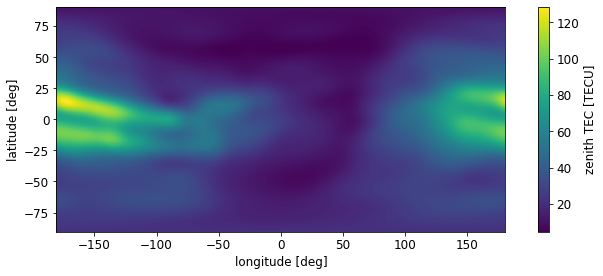

In [10]:
gim_tec_dir = os.path.join(proj_dir, 'GIM_TEC')
tec_file = os.path.join(gim_tec_dir, 'gim_150209_0200_0215.tecgrd.txt')
lat, lon, vtec = iono.read_gim_tec_grid_file(tec_file, display=True)